# To html
python -m nbconvert --to html research.ipynb

# Load price data


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

path = "C:/Users/itataurov/Desktop/ccxt_data/data_parsed/1d/technical/binance/joined/binance_perps_joined.parquet"

df = pd.read_parquet(path)
df.rename(columns={'datetime':'timestamp'}, inplace=True)
df = df.sort_values(by=['timestamp'])

# Universe growth

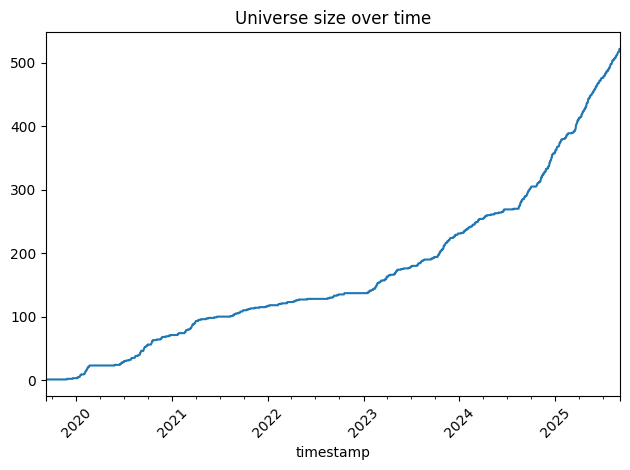

In [2]:
# plot universe size over time
df.groupby('timestamp').size().plot()
plt.title("Universe size over time")
plt.xticks(rotation=45)
plt.tight_layout()

In [3]:
# Add forward returns
def add_n_day_forward_returns(df, n):
	# print(f"Adding {n} period forward returns")
	df[f"fwd_return_{n}d"] = (
		df.groupby("symbol")["close"]
		.transform(lambda x: x.shift(-n) / x - 1)
	)
	
	# Define a helper that computes the future sum using reversed rolling window
	def future_sum(series, n):
		# Reverse the series so that future values become the "past"
		rev = series.iloc[::-1]
		# Compute a rolling sum on the reversed series; use min_periods=n to only include rows with a full window
		rolled = rev.rolling(window=n, min_periods=n).sum().iloc[::-1]
		# Shift by -1 to align each row with the sum of the NEXT n periods (i.e., skip the current row)
		return rolled.shift(-1)
	
	# Apply the helper to each group and make sure to reset the index to match df
	df[f'fwd_funding_return_{n}d'] = df.groupby('symbol')['fundingRate'] \
									   .apply(lambda s: future_sum(s, n)) \
									   .reset_index(level=0, drop=True)
	# combined
	df[f'fwd_combined_return_{n}d'] = df[f'fwd_return_{n}d'] - df[f'fwd_funding_return_{n}d']
	return df

for n in range(1, 61):
	df = add_n_day_forward_returns(df, n)

# copy df to de-fragment it
df = df.copy()

C:\Users\itataurov\AppData\Local\Temp\ipykernel_28528\4202132967.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'fwd_funding_return_{n}d'] = df.groupby('symbol')['fundingRate'] \
C:\Users\itataurov\AppData\Local\Temp\ipykernel_28528\4202132967.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'fwd_combined_return_{n}d'] = df[f'fwd_return_{n}d'] - df[f'fwd_funding_return_{n}d']
C:\Users\itataurov\AppData\Local\Temp\ipykernel_28528\4202132967.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usual

In [4]:
# make vol a mix of long term(using expanding window) and short term (using ewm)
df['return'] = df.groupby('symbol')['close'].pct_change()
df['vol_expanding_window'] = (
	df.groupby('symbol')['return']
		.transform(lambda x: x
					.expanding(min_periods=30)
					.std())
)
df['vol_ewm'] = (
	df.groupby('symbol')['return']
		.transform(lambda x: x
					.ewm(span=30, adjust=False, min_periods=30)
					.std())
)
df['volatility'] = (
	df['vol_expanding_window'] * 0.25 +
	df['vol_ewm'] * 0.75
)

In [5]:
# Universe selection
df['dollar_volume'] = df['close'] * df['volume']
df['dollar_volume_slowed'] = (
	df.groupby('symbol')['dollar_volume']
		.transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
)
df['dv_rank'] = (
	df.groupby('timestamp')['dollar_volume_slowed']
		.rank(method='first', ascending=False)
		.fillna(1000000)
		.astype(int)
)
df['dv_decile'] = df.groupby('timestamp')['dollar_volume_slowed'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1

df['market_cap_slowed'] = (
	df.groupby('symbol')['mkt_cap']
		.transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
)
df['mc_rank'] = (
	df.groupby('timestamp')['market_cap_slowed']
		.rank(method='first', ascending=False)
		.fillna(1000000)
		.astype(int)
)
df['mc_decile'] = df.groupby('timestamp')['market_cap_slowed'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1

# days since listing
df['days_since_listing'] = df.groupby('symbol').cumcount() + 1

# Filter illiquids 

In [6]:
# Select universe
df_filtered = df[df.dollar_volume_slowed >= 1e6] # at least $1M daily volume 
df_filtered = df[df['days_since_listing'] >= 90] # at least 90 days since listing (need data for risk estimate)
df_filtered = df_filtered[df_filtered.timestamp<'2025-01-01']
df_filtered = df_filtered[df_filtered.timestamp>'2021-01-01']
print(f"Filtered down from {len(df)} to {len(df_filtered)} rows")

Filtered down from 371753 to 226544 rows


In [7]:
# demean forward returns (old + slow)
# for n in range(1, 61):
# 	print(f"Demeaning forward returns {n}")
# 	df_filtered[f'fwd_return_{n}d_demeaned'] = df_filtered.groupby('timestamp')[f'fwd_return_{n}d'].transform(lambda x: x - x.mean())
# 	df_filtered[f'fwd_funding_return_{n}d_demeaned'] = df_filtered.groupby('timestamp')[f'fwd_funding_return_{n}d'].transform(lambda x: x - x.mean())
# 	# combined
# 	df_filtered[f'fwd_combined_return_{n}d_demeaned'] = df_filtered.groupby('timestamp')[f'fwd_combined_return_{n}d'].transform(lambda x: x - x.mean())

# 1) define your three 60-column groups
price_cols    = [f"fwd_return_{n}d"          for n in range(1, 61)]
funding_cols  = [f"fwd_funding_return_{n}d"  for n in range(1, 61)]
combined_cols = [f"fwd_combined_return_{n}d" for n in range(1, 61)]

# 2) vectorized demean in-place, naming *_demeaned_fast
for cols in (price_cols, funding_cols, combined_cols):
	# compute per-timestamp means for all cols at once
	means = df_filtered.groupby("timestamp")[cols].transform("mean")
	# subtract and assign to new *_demeaned_fast columns
	fast_cols = [f"{c}_demeaned" for c in cols]
	df_filtered[fast_cols] = df_filtered[cols] - means

df_filtered = df_filtered.copy() # de-fragment

C:\Users\itataurov\AppData\Local\Temp\ipykernel_28528\2851541766.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_filtered[fast_cols] = df_filtered[cols] - means
C:\Users\itataurov\AppData\Local\Temp\ipykernel_28528\2851541766.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_filtered[fast_cols] = df_filtered[cols] - means
C:\Users\itataurov\AppData\Local\Temp\ipykernel_28528\2851541766.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

In [8]:
df_filtered.columns[0:30]

Index(['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'mkt_cap', 'fundingRate', 'oi', 'ls_ratio', 'longs_pct',
       'buy_volume_perp', 'total_volume_perp', 'buy_trades_perp',
       'total_trades_perp', 'spot_close', 'buy_volume_spot',
       'total_volume_spot', 'buy_trades_spot', 'total_trades_spot',
       'predicted_funding_rate', 'short_liquidation_volume',
       'long_liquidation_volume', 'fwd_return_1d', 'fwd_funding_return_1d',
       'fwd_combined_return_1d', 'fwd_return_2d', 'fwd_funding_return_2d',
       'fwd_combined_return_2d'],
      dtype='object')

# Compute Signal

In [58]:
df['mkt_cap'].describe()

count    3.185140e+05
mean     9.189548e+09
std      8.639653e+10
min      0.000000e+00
25%      7.715318e+07
50%      2.384472e+08
75%      8.955588e+08
max      2.454979e+12
Name: mkt_cap, dtype: float64

In [ ]:
def winsorize(x, lower_pct, upper_pct):
	lo, hi = x.quantile(lower_pct), x.quantile(upper_pct)
	return x.clip(lower=lo, upper=hi)

def compute_signal(df, lookback, signal_name):
	df[signal_name] = df.groupby('symbol')['fundingRate'].transform(lambda x: x.ewm(span=lookback, adjust=False).std())

	# winsorize per day
	df[signal_name] = df.groupby('timestamp')[signal_name].transform(lambda x: winsorize(x, 0.05, 0.95))

	# drop intermediates
	return df

lookbacks = [1,2, 4, 8, 16, 32, 64, 128]

for l in lookbacks:
	print(f"Computing signal for lookback {l}")
	df_filtered = compute_signal(df_filtered, l, f'signal_{l}d')


Computing signal for lookback 1
Computing signal for lookback 2


# Visualize signals

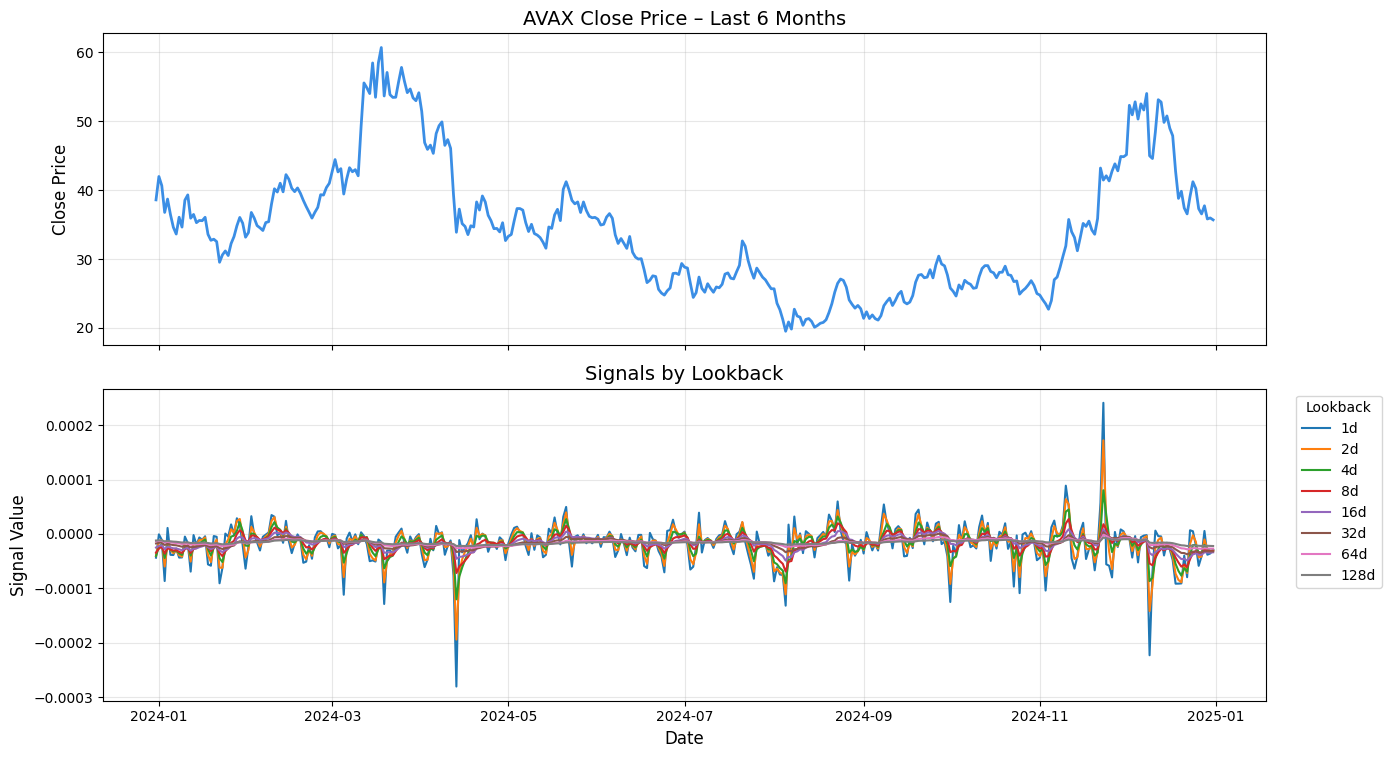

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --- AVAX slice, last 12 months ----------------------------
btc = df_filtered[df_filtered['symbol'] == 'AVAX'].copy()
btc['timestamp'] = pd.to_datetime(btc['timestamp'])
end   = btc['timestamp'].max()
start = end - pd.DateOffset(months=12)
btc   = btc[btc['timestamp'] >= start]

# --- plot: price on top, signals bottom (equal height) ------------------
fig, (ax1, ax2) = plt.subplots(
	nrows=2,
	ncols=1,
	sharex=True,
	figsize=(14, 8),
	gridspec_kw={"height_ratios": [1, 1]}  # equal heights
)

# Top: AVAX price
ax1.plot(btc['timestamp'], btc['close'], color="#3B8EE5", lw=2)
ax1.set_ylabel('Close Price', fontsize=12)
ax1.set_title('AVAX Close Price – Last 6 Months', fontsize=14)
ax1.grid(True, alpha=0.3)

# Bottom: signals
for l in lookbacks:
	ax2.plot(
		btc['timestamp'],
		btc[f'signal_{l}d'],
		lw=1.5,
		label=f'{l}d'
	)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Signal Value', fontsize=12)
ax2.set_title('Signals by Lookback', fontsize=14)
ax2.legend(
	title='Lookback',
	bbox_to_anchor=(1.02, 1),
	loc='upper left'
)
ax2.grid(True, alpha=0.3)

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Lookback selection

### IC vs lookback

1
2
4
8
16
32
64
128


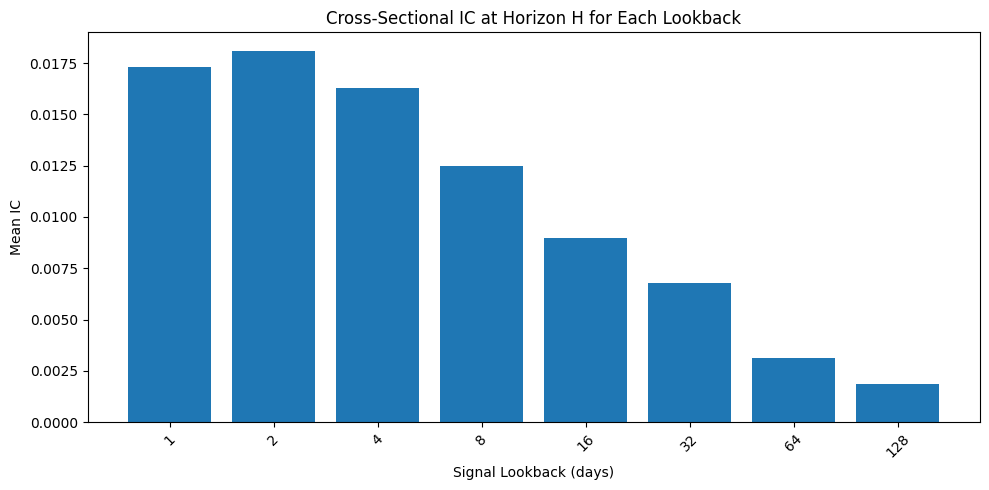

          avg_turnover  avg_hold_days  horizon_H        IC
lookback                                                  
1             0.989582       1.010528          5  0.017318
2             0.610703       1.637457          5  0.018095
4             0.376411       2.656672          5  0.016269
8             0.217481       4.598105          5  0.012460
16            0.121906       8.203020          5  0.008984
32            0.070672      14.149786          5  0.006784
64            0.042965      23.274615          5  0.003121
128           0.028114      35.569110          5  0.001864


In [ ]:
results = []

for l in lookbacks:
	print(l)
	sig_col = f"signal_{l}d"

	# ——— 1) build the raw signal matrix, with NaNs for missing symbols ———
	S = df_filtered.pivot(
		index="timestamp",
		columns="symbol",
		values=sig_col,
	)  # missing value -> NaN

	# ——— 2) subtract the cross‐sectional mean (skipna=True by default) ———
	S0 = S.sub(S.mean(axis=1), axis=0)

	# ——— 3) normalize by the sum of abs deviations (skipna=True) ———
	norm = S0.abs().sum(axis=1)
	W = S0.div(norm, axis=0)

	# ——— 4) put missing positions back to 0 (just like your unstack(fill_value=0)) ———
	W = W.fillna(0)

	# ——— 5) turnover exactly as before ———
	daily_turnover = W.diff().abs().sum(axis=1).iloc[1:]
	avg_turn       = daily_turnover.mean()
	avg_hold       = 1.0 / avg_turn
	H              = 5 #int(round(avg_hold))

	# ——— 6) horizon‐matched IC exactly as before ———
	ret_col   = f"fwd_combined_return_{H}d_demeaned"
	daily_ics = (
		df_filtered
		.groupby("timestamp")[[sig_col, ret_col]]
		.apply(lambda g: g.iloc[:, 0].corr(g.iloc[:, 1], min_periods=2))
		.dropna()
	)
	ic_H = daily_ics.mean()

	results.append({
		"lookback":      l,
		"avg_turnover":  avg_turn,
		"avg_hold_days": avg_hold,
		"horizon_H":     H,
		"IC":            ic_H,
	})

metrics = pd.DataFrame(results).set_index("lookback")

plt.figure(figsize=(10, 5))
plt.bar(metrics.index.astype(str), metrics["IC"])
plt.title("Cross-Sectional IC at Horizon H for Each Lookback")
plt.xlabel("Signal Lookback (days)")
plt.ylabel("Mean IC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(metrics)


# Signal Selection

In [ ]:
df_filtered['signal'] = df_filtered['signal_2d']

Holding-period estimator ``H = 1/avg_turnover`` assumes ``GMV = 1``.

In [ ]:
# find turnover for future plots
df_filtered['weight'] = df_filtered.groupby('timestamp')['signal'].transform(
		lambda x: (x - x.mean()) / (x - x.mean()).abs().sum()
)
W = df_filtered.pivot(values='weight', columns='symbol', index='timestamp')
avg_holding_period = 1/W.diff().abs().sum(axis=1).mean()
print(f"Avg holding period: {avg_holding_period:.2f}")

Avg holding period: 1.65


# Signal distribution

Five-number summary:
  Min     : -0.0191
  25th %ile: -0.0002
  Median  : -0.0000
  75th %ile: -0.0000
  Max     : 0.0076


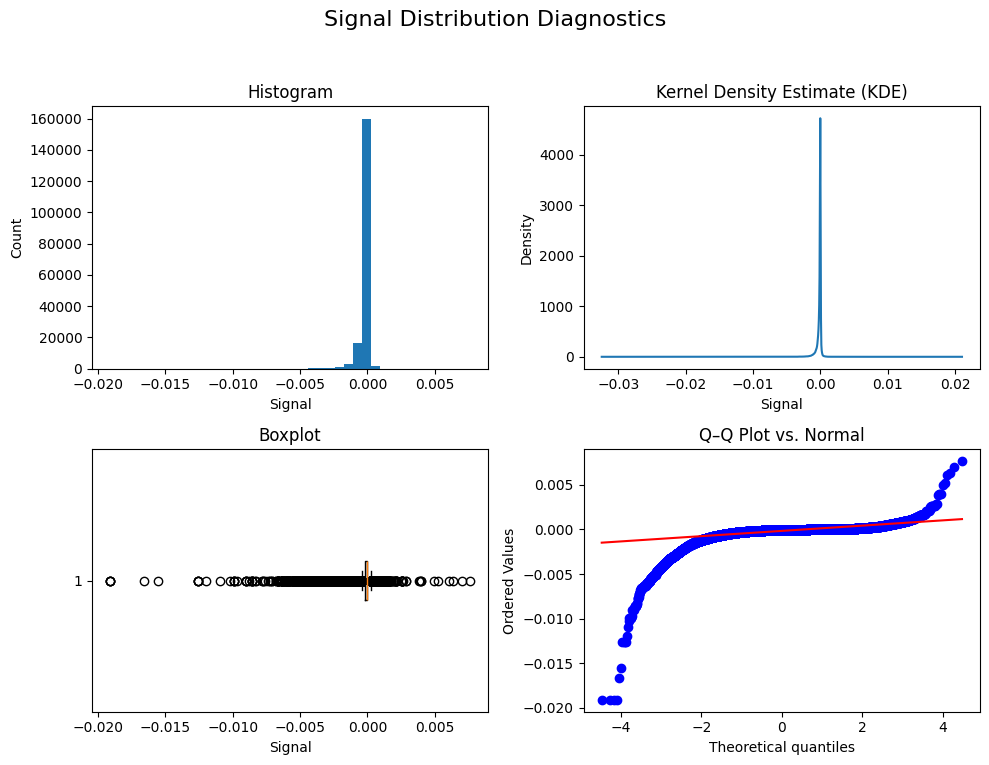

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

# extract and clean
signal = df_filtered['signal'].dropna()

# compute five-number summary
five_num = signal.quantile([0, .25, .5, .75, 1.0])
print("Five-number summary:")
print(f"  Min     : {five_num.loc[0.00]:.4f}")
print(f"  25th %ile: {five_num.loc[0.25]:.4f}")
print(f"  Median  : {five_num.loc[0.50]:.4f}")
print(f"  75th %ile: {five_num.loc[0.75]:.4f}")
print(f"  Max     : {five_num.loc[1.00]:.4f}")

# set up 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Signal Distribution Diagnostics', fontsize=16)

# 1. Histogram
axes[0, 0].hist(signal, bins=40)
axes[0, 0].set_title('Histogram')
axes[0, 0].set_xlabel('Signal')
axes[0, 0].set_ylabel('Count')

# 2. KDE
signal.plot.kde(ax=axes[0, 1])
axes[0, 1].set_title('Kernel Density Estimate (KDE)')
axes[0, 1].set_xlabel('Signal')

# 3. Boxplot
axes[1, 0].boxplot(signal, vert=False)
axes[1, 0].set_title('Boxplot')
axes[1, 0].set_xlabel('Signal')

# 4. Q–Q Plot
st.probplot(signal, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q–Q Plot vs. Normal')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Performance by ADV decile

dv_decile
1.0    -0.051647
2.0    -0.044218
3.0    -0.018354
4.0    -0.036894
5.0    -0.021060
6.0    -0.016684
7.0    -0.014456
8.0    -0.051583
9.0    -0.004175
10.0   -0.019937
dtype: float64


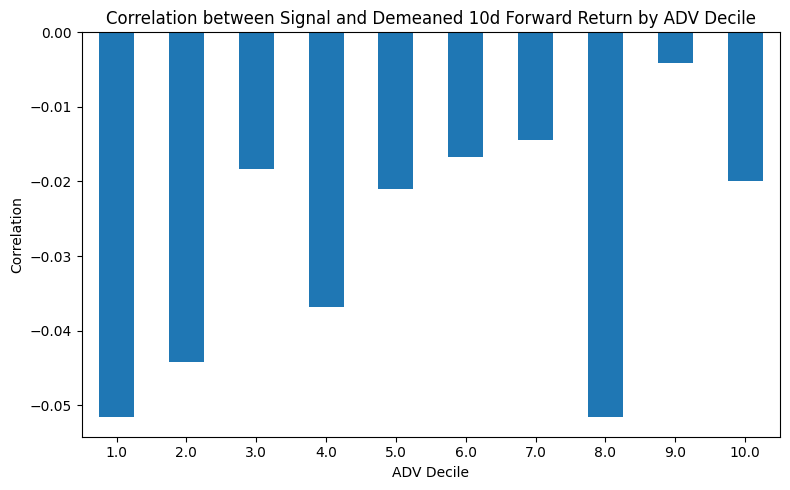

In [ ]:
# Assuming df_filtered is already defined from earlier cells
# Compute correlation by dv_decile: demean fwd_combined_return_5d within each group, then corr with signal
correlations = df_filtered.groupby('dv_decile')[['signal', 'fwd_combined_return_5d']].apply(
	lambda g: g['signal'].corr(g['fwd_combined_return_5d'] - g['fwd_combined_return_5d'].mean())
)

# Print the results (Series with dv_decile as index)
print(correlations)

# Optional: Plot for visualization
import matplotlib.pyplot as plt
correlations.plot(kind='bar', figsize=(8, 5))
plt.title('Correlation between Signal and Demeaned 10d Forward Return by ADV Decile')
plt.xlabel('ADV Decile')
plt.ylabel('Correlation')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Regression fit

In [ ]:
import statsmodels.api as sm
import numpy as np

# Choose which model to fit
use_interaction = False   # set False if you only want signal

if use_interaction:
    dataset = df_filtered[['signal', 'dv_decile', 'fwd_combined_return_5d_demeaned']].dropna()

    # Create interaction term
    dataset['signal_x_dv_decile'] = dataset['signal'] * dataset['dv_decile']

    X = dataset[['signal', 'dv_decile', 'signal_x_dv_decile']]
    y = dataset['fwd_combined_return_5d_demeaned']

    # Add constant
    X = sm.add_constant(X)

    # Fit model
    model = sm.OLS(y, X).fit()

    # Extract coefficients
    intercept        = model.params['const']
    coef_signal      = model.params['signal']
    coef_dv_decile   = model.params['dv_decile']
    coef_interaction = model.params['signal_x_dv_decile']

    # Forecast
    df_filtered['forecast'] = (
        intercept
        + coef_signal * df_filtered['signal']
        + coef_dv_decile * df_filtered['dv_decile']
        + coef_interaction * df_filtered['signal'] * df_filtered['dv_decile']
    )

else:
    dataset = df_filtered[['signal', 'fwd_combined_return_5d_demeaned']].dropna()

    X = sm.add_constant(dataset[['signal']])
    y = dataset['fwd_combined_return_5d_demeaned']

    model = sm.OLS(y, X).fit()

    # Extract coefficients
    intercept   = model.params['const']
    coef_signal = model.params['signal']

    # Forecast
    df_filtered['forecast'] = intercept + coef_signal * df_filtered['signal']

dataset = df_filtered[['dv_decile', 'fwd_combined_return_5d_demeaned']].dropna()

print(model.summary())


                                   OLS Regression Results                                  
Dep. Variable:     fwd_combined_return_5d_demeaned   R-squared:                       0.000
Model:                                         OLS   Adj. R-squared:                  0.000
Method:                              Least Squares   F-statistic:                     18.59
Date:                             Thu, 11 Sep 2025   Prob (F-statistic):           1.62e-05
Time:                                     09:51:38   Log-Likelihood:             1.6056e+05
No. Observations:                           176319   AIC:                        -3.211e+05
Df Residuals:                               176317   BIC:                        -3.211e+05
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

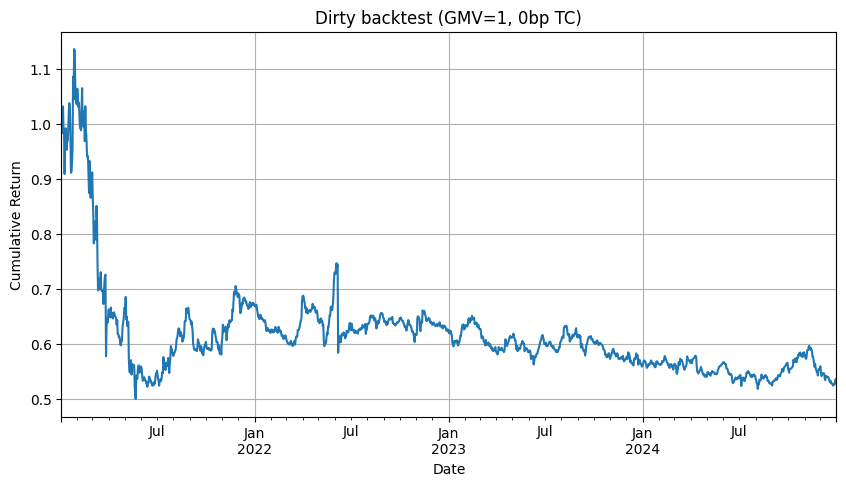

In [ ]:
signals_wide = df_filtered.pivot(index='timestamp', columns='symbol', values='forecast')
df_filtered['return'] = df_filtered.groupby('symbol')['close'].pct_change()
returns_wide = df_filtered.pivot(index='timestamp', columns='symbol', values='return')

# generate stat-arb weights (demean + l1 norm)
W = signals_wide.sub(signals_wide.mean(axis=1), axis=0)
W = W.div(W.abs().sum(axis=1), axis=0)
W = W.fillna(0)

# compute daily PnL
pnl = (W.shift(1) * returns_wide).sum(axis=1)

# TC
turnover = (W.fillna(0) - W.shift(1).fillna(0)).abs().sum(axis=1)  # one-way traded notional
cost_bps = 0  # e.g., 1bp per one-way
pnl = pnl - (cost_bps/1e4) * turnover

# plot cumulative PnL
(pnl + 1).cumprod().plot(figsize=(10, 5))
plt.title(f"Dirty backtest (GMV=1, {cost_bps}bp TC)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()